In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
from scipy import stats
from scipy.integrate import quad
import scipy.linalg as la
import seaborn as sns
from functools import partial

# Abbreviated lecture notes

In [2]:
np.random.seed(123)

## Monte Carlo integration

We want to find some integral 

$$I = \int{f(x)} \, dx$$

Consider the expectation of a function $g(x)$ with respect to some distribution $p(x)$. By definition, we have

$$
E[g(x)] = \int{g(x) \, p(x) \, dx}
$$

If we choose $g(x) = f(x)/p(x)$, then we have

$$
\begin{align}
E[g(x)] &= \int{\frac{f(x}{p(x)} \, p(x) \, dx} \\
&= \int{f(x) dx} \\
&= I
\end{align}
$$

By the law of large numbers, the average converges on the expectation, so we have

$$
I \approx \bar{g_n} = \frac{1}{n} \sum_{i=1}^n g(x_i)
$$

If $f(x)$ is a proper integral (i.e. bounded), and $p(x)$ is the uniform distribution, then $g(x) = f(x)$ and this is known as ordinary Monte Carlo. If the integral of $f(x)$ is improper, then we need to use another distribution with the same support as $f(x)$.

### Steps

Draw $n$ random samples $x_i$ from some probability distribution $p(x)$ with thee same support as the function $f(x)$. Then calculate

$$
I \approx \frac{1}{n}\sum_{i=1}^n \frac{f(x_i)}{p(x_i)}
$$

### Example 1

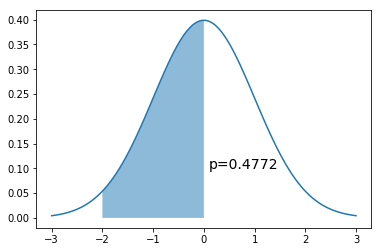

In [3]:
x = np.linspace(-3,3,100)
dist = stats.norm(0,1)
a = -2
b = 0
plt.plot(x, dist.pdf(x))
plt.fill_between(np.linspace(a,b,100), dist.pdf(np.linspace(a,b,100)), alpha=0.5)
plt.text(b+0.1, 0.1, 'p=%.4f' % (dist.cdf(b) - dist.cdf(a)), fontsize=14)
pass

#### Monte Carlo integral

If we cannot sample directly from the target distribution $N(0,1)$ but can evaluate it at any point. 

Since $p(x)$ is $U(a, b)$, $p(x) = \frac{1}{b-a}$. So we want to calculate

$$
\frac{1}{n} \sum_{i=1}^n (b-a) f(x)
$$

In [4]:
n = 10000
x = np.random.uniform(a, b, n)
np.mean((b-a)*dist.pdf(x))

0.47631158517865363

### Example 2

In [5]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

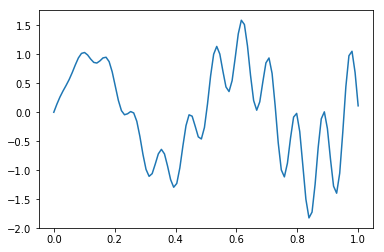

In [6]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Monte Carlo integral

In [7]:
n = int(1e6)
x = f(np.random.random(n))
y = 1.0/n * np.sum(x)
y

0.020342363216455394

Check

In [8]:
y, err = quad(f, 0, 1.0)
y

0.02025493910239419

### How many Monte Carlo samples do we need?

We are often interested in knowing how many iterations it takes for Monte Carlo integration to "converge". To do this, we would like some estimate of the variance, and it is useful to inspect such plots. One simple way to get confidence intervals for the plot of Monte Carlo estimate against number of iterations is simply to do many such simulations. This might be expensive, so we show instead how to estimate convergence using bootstrap.

We find the Monte Carlo samples once for 100 steps

In [9]:
n = 100
x = f(np.random.uniform(a, b, n))

In [10]:
x.shape

(100,)

In [11]:
x[:5]

array([-0.92731533, -0.54132811, -0.85450052, -0.57789469, -0.6274338 ])

A single MC integral 

In [12]:
y = 1.0/n * np.sum(x)
y

-0.06417233839386707

Use sampling without replacement to make copies

In [13]:
reps = 1000
xb = np.random.choice(x, (n, reps), replace=True)

In [14]:
xb.shape

(100, 1000)

Each column is a bootstrap replicate of the Monte Carlo samples

In [15]:
xb[:5, 0]

array([ 1.47414827,  1.76137976, -0.85450052,  1.87386139, -0.02133597])

In [16]:
xb[:5, 1]

array([-1.01541359, -0.90344323,  0.68736292,  0.14541681,  0.98707994])

In [17]:
xb[:5, 2]

array([-0.54132811, -0.81092802, -1.01712687, -1.07677473,  0.98707994])

Calculate the Monte Carlo estimate among the replicates for Monte Carlo sequences of length 1, 2, ..., n

In [18]:
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)

In [19]:
yb.shape

(100, 1000)

Calculate the ($\alpha/2$, 1-$\alpha/2$) intervals for plotting the CI envelope at each step 1, 2, ..., n

In [20]:
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

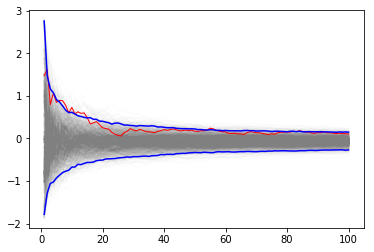

In [21]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

## Markov chain Monte Carlo (MCMC)

In Bayesian statistics, we want to estimate the posterior distribution, but this is often intractable due to the high-dimensional integral in the denominator (marginal likelihood). A few other ideas we have encountered that are also relevant here are Monte Carlo integration with independent samples and the use of proposal distributions (e.g. rejection and importance sampling). As we have seen from the Monte Carlo integration lectures, we can approximate the posterior $p(\theta | X)$ if we can somehow draw many samples that come from the posterior distribution. With vanilla Monte Carlo integration, the samples are independent draws from the posterior distribution.

With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don't need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since `posterior` $\propto$ `likelihood` $\times$ `prior`. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration. 

All MCMC sampling schemes have the following structure:

Start with some state $x_k$

Repeat 

1. Draw a sample $x_{k+1}$ from a proposal distribution $p(x_k)$
2. Calculate the acceptance probability $A(x)$ - in general, this is a function of the proposal and target distributions at $x_k$ and $x_{k+1}$
3. Choose a standard random uniform number $r$
4. If $r < A(x)$ set state to be $x_{k+1}$, otherwise keep state as $x_{k}$

### Metropolis-Hastings

To carry out the Metropolis-Hastings algorithm, we need to draw random samples from the following distributions

- the standard uniform distribution
- a proposal distribution $p(x)$ 
- the target distribution $g(x)$ which is proportional to the posterior probability

Given an initial guess for $\theta$ with positive probability of being drawn, the Metropolis-Hastings algorithm proceeds as follows

- Choose a new proposed value ($\theta_p$) such that  $\theta_p = \theta + \Delta\theta$ where $\Delta \theta \sim p$
- If $p$ is a symmetrical distribution, calculate the ratio

$$
\rho = \frac{g(\theta_p \ | \ X)}{g(\theta \ | \ X)} 
$$

where $g$ is the posterior probability. 

- If the proposal distribution is not symmetrical, we need to weight the acceptance probability to maintain detailed balance (reversibility) of the stationary distribution, and instead calculate

$$
\rho = \frac{g(\theta_p \ | \ X) p(\theta \ | \ \theta_p)}{g(\theta \ | \ X) p(\theta_p \ | \ \theta)} 
$$

Since we are taking ratios, the denominator cancels any distribution proportional to $g$ will also work - so we can use 

$$
\rho = \frac{g(X | \theta_p ) p(\theta_p)}{g(X | \theta ) p(\theta)}
$$
 
- If $\rho \ge 1$, then set $\theta = \theta_p$
- If $\rho \lt 1$, then set $\theta = \theta_p$ with probability $\rho$, otherwise set $\theta = \theta$ (this is where we use the standard uniform distribution)
- Repeat the earlier steps

After some number of iterations $k$, the samples $\theta_{k+1}, \theta_{k+2}, \dots$ will be samples from the posterior distributions. Here are initial concepts to help your intuition about why this is so:

- We accept a proposed move to $\theta_{k+1}$ whenever the density of the (unnormalized) target distribution at $\theta_{k+1}$ is larger than the value of $\theta_k$ - so $\theta$ will more often be found in places where the target distribution is denser
- If this was all we accepted, $\theta$ would get stuck at a local mode of the target distribution, so we also accept occasional moves to lower density regions - it turns out that the correct probability of doing so is given by the ratio $\rho$
- The acceptance criteria only looks at ratios of the target distribution, so the denominator cancels out and does not matter - that is why we only need samples from a distribution proportional to the posterior distribution
- So, $\theta$ will be expected to bounce around in such a way that its spends its time in places proportional to the density of the posterior distribution - that is, $\theta$ is a draw from the posterior distribution. 

Additional notes:

Different proposal distributions can be used for Metropolis-Hastings:

- The independence sampler uses a proposal distribution that is independent of the current value of $\theta$. In this case the proposal distribution needs to be similar to the posterior distribution for efficiency, while ensuring that the acceptance ratio is bounded in the tail region of the posterior.
- The random walk sampler (used in this example) takes a random step centered at the current value of $\theta$ - efficiency is a trade-off between small step size with high probability of acceptance and large step sizes with low probability of acceptance. Note (picture will be sketched in class) that the random walk may take a long time to traverse narrow regions of the probability distribution. Changing the step size (e.g. scaling $\Sigma$ for a multivariate normal proposal distribution) so that a target proportion of proposals are accepted is known as *tuning*.
- Much research is being conducted on different proposal distributions for efficient sampling of the posterior distribution.

### Example 1

Using MCMC to generate standard normal samples from uniform samples.

- The proposal density $p(x)$ is uniform on an interval centered at current state (hence symmetrical)
- The target density $q(x)$ is $N(0,1)$ which is proportional to $e^{-x^2/2}$
- The acceptance function $A(x)$ is 
$$
\frac{e^{-x_{k+1}^2/2}}{e^{-x_{k}^2/2}} = e^{-(x_{k+1}^2-x_{k}^2)/2}
$$

In [22]:
n = 10000
xs = np.zeros(n)
x = 0
for i in range(n):
    p = np.random.uniform(x-1, x+1)
    a = np.exp(-(p**2-x**2)/2)
    r = np.random.rand()
    if r < a:
        x = p
    xs[i] = x

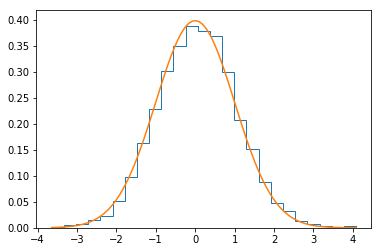

In [23]:
plt.hist(xs, 25, histtype='step', normed=True)
xp = np.linspace(xs.min(), xs.max(), 100)
plt.plot(xp, stats.norm().pdf(xp))
pass

### Gibbs sampler

Suppose we have a vector of parameters $\theta = (\theta_1, \theta_2, \dots, \theta_k)$, and we want to estimate the joint posterior distribution $p(\theta | X)$. Suppose we can find and draw random samples from all the conditional distributions 

$$
p(\theta_1 | \theta_2, \dots \theta_k, X) \\
p(\theta_2 | \theta_1, \dots \theta_k, X) \\
\dots \\
p(\theta_k | \theta_1, \theta_2, \dots, X) 
$$

With Gibbs sampling, the Markov chain is constructed by sampling from the conditional distribution for each parameter $\theta_i$ in turn, treating all other parameters as observed. When we have finished iterating over all parameters, we are said to have completed one cycle of the Gibbs sampler. Since hierarchical models are typically set up as products of conditional distributions, the Gibbs sampler is ubiquitous in Bayesian modeling. Where it is difficult to sample from a conditional distribution, we can sample using a Metropolis-Hastings algorithm instead - this is known as Metropolis within Gibbs. 

Gibbs sampling is a type of random walk through parameter space, and hence can be thought of as a Metropolis-Hastings algorithm with a special proposal distribution. At each iteration in the cycle, we are drawing a proposal for a new value of a particular parameter, where the proposal distribution *is* the conditional posterior probability of that parameter. This means that the proposal move is *always* accepted. Hence, if we can draw samples from the conditional distributions, Gibbs sampling can be much more efficient than regular Metropolis-Hastings. 
More formally, we want to show that 

$$
\frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} = 1
$$

We start by noting that $P(x_{-i})$ is the same as $P(y_{-i})$ since apart from the component $i$, the old state and the proposed new state are identical in Gibbs sampling. We also recall that 

$$P(x_i \mid x_{-i}) \, P(x_{-i}) = P(x_i, x_{-i}) = P(x)$$ 

by definition of conditional probability. So we have

$$
\begin{align}
\frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} &= \frac{P(y_i \mid y_{-1}) \, P(y_{-i})\, P(x_i \mid x_{-i}) }{P(x_i \mid x_{-i}) \, P(x_{-i})\, P(y_i \mid y_{-1})} &= 1
\end{align}
$$


**Advantages of Gibbs sampling**

- No need to tune proposal distribution
- Proposals are always accepted

**Disadvantages of Gibbs sampling**

- Need to be able to derive conditional probability distributions 
- Need to be able to (cheaply) draw random samples from conditional probability distributions
- Can be very slow if parameters are correlated because you cannot take "diagonal" steps (draw picture to illustrate)

#### Example: Bivariate normal distribution

Suppose we want to draw samples from a bivariate normal distribution $(X, Y)$ with correlation $\rho$

$$
\mu = 
\begin{bmatrix}
0 \\ 0 
\end{bmatrix}
$$

$$
\Sigma = 
\begin{bmatrix}
1 & \rho \\
\rho & 1
\end{bmatrix}
$$

Then the conditional distributions are given by

$$
p(X \vert y) = N(\rho y, 1-\rho^2)
$$

and 

$$
p(Y \vert x) = N(\rho x, 1-\rho^2)
$$

and the Gibbs sampler is

```
Start with initial guess for y
Repeat
    x = N(rho*y, 1-rho**2)
    y = N(rho*x, 1-rho**2)
```

In [24]:
rho = -0.8
niter = 1000
xs = np.zeros((niter, 2))
y = 0
for i in range(niter):
    x = np.random.normal(rho*y, 1-rho**2)
    y = np.random.normal(rho*x, 1-rho**2)
    xs[i,:] = x,y

In [25]:
dist = stats.multivariate_normal([0,0], np.array([[1,rho],[rho,1]]))

x = np.linspace(-3.0, 3.0, 100)
y = np.linspace(-3.0, 2.0, 100)
X, Y = np.meshgrid(x, y)
Z = dist.pdf(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)

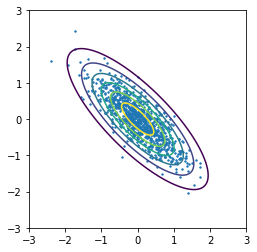

In [26]:
plt.contour(X, Y, Z)
plt.scatter(xs[:, 0], xs[:, 1], s=2)
plt.axis('square')
pass

### Hamiltonian Monte Carlo (HMC)

HMC uses an auxiliary variable corresponding to the momentum of particles in a potential energy well to generate proposal distributions that can make use of gradient information in the posterior distribution. For reversibility to be maintained, the total energy of the particle has to be conserved - hence we are interested in Hamiltonian systems. The main attraction of HMC is that it works much better than other methods when variables of interest are highly correlated. Because we have to solve problems involving momentum, we need to understand how to numerically solve differential equations in a way that is both accurate (i.e. second order) and preserves total energy (necessary for a Hamiltonian system).

Example adapted from [MCMC: Hamiltonian Monte Carlo (a.k.a. Hybrid Monte Carlo)](https://theclevermachine.wordpress.com/2012/11/18/mcmc-hamiltonian-monte-carlo-a-k-a-hybrid-monte-carlo/)

#### Hamiltonian systems

In a Hamiltonian system, we consider particles with position $x$ and momentum (or velocity if we assume unit mass) $v$. The total energy of the system $H(x, v) = K(v) + U(x)$, where $K$ is the kinetic energy and $U$ is the potential energy, is conserved. Such a system satisfies the following Hamiltonian equations

$$
\begin{align}
\frac{dx}{dt} &= & \frac{\delta H}{dv} \\
\frac{dv}{dt} &= & -\frac{\delta H}{dx} 
\end{align}
$$

Since $K$ depends only on $v$ and $U$ depends only on $x$, we have
$$
\begin{align}
\frac{dx}{dt} &= & \frac{\delta K}{dv} \\
\frac{dv}{dt} &= & -\frac{\delta U}{dx}
\end{align}
$$

#### Harmonic oscillator

We will consider solving a classical Hamiltonian system - that of a undamped spring governed by the second order differential equation

$$
x'' + x = 0
$$

We convert this to two first order ODEs by using a dummy variable $x' = v$ to get

$$
\begin{align}
x' &= v \\
v' &= -x
\end{align}
$$

From the Hamiltonian equations above, this is equivalent to a system with kinetic energy $K(v) = \frac{1}{2}v^2$ and potential energy $U(x) = \frac{1}{2}x^2$.

Writing in matrix form,

$$
A = \pmatrix{ x' \\ v' } = \pmatrix{0 & 1 \\ -1 & 0} \pmatrix{x \\ v}
$$

and in general, for the state vector $x$,

$$
x' = Ax
$$

We note that $A$ is anti- or skew-symmetric ($A^T = -A$), and hence has purely imaginary eigenvalues. Solving $|A - \lambda I = 0$, we see that the eigenvalues and eigenvectors are $i, \pmatrix{1\\i}$ and $-i, \pmatrix{1\\-i}$. Since the eigenvalues are pure imaginary, we see that the solution for the initial conditions $(x,v) = (1, 0)$ is $x(t) = e^{it}$ and the orbit just goes around a circle with a period of $2\pi$, neither growing nor decaying. Another weay of seeing this is that the Hamiltonian $H(u, v)$ or sum of potential ($U(x)) = \frac{1}{2}x^2$) and kinetic energy ($K(v) = \frac{1}{2}v^2$) is constant, i.e. in vector form, $(x^T x) = \text{constant}$.

#### Finite difference methods

We want to find a finite difference approximation to $u' = Au$ that is **accurate** and **preserves total energy**. If total energy is not preserved, the orbit will either spiral in towards zero or outwards away from the unit circle. If the accuracy is poor, the orbit will not be close to its starting value after $t = 2\pi$. This gives us an easy way to visualize how good our numerical scheme is. We can also compare the numerical scheme to the Taylor series to evaluate its accuracy.

##### The leapfrog method

The leapfrog method uses a second order difference to update $u_n$. The algorithm simplifies to the following explicit scheme:

- First take one half-step for v
- Then take a full step for u
- Then take one final half step for v

It performs as well as the trapezoidal method, with the advantage of being an explicit scheme and cheaper to calculate, so the leapfrog method is used in HMC.

In [27]:
def leapfrog(A, u, N):
    orbit = np.zeros((N,2))

    dt = 2*np.pi/N
    for i in range(N):
        u[1] = u[1] + dt/2 * A[1] @ u
        u[0] = u[0] + dt * A[0] @ u
        u[1] = u[1] + dt/2 * A[1] @ u
        orbit[i] = u
    return orbit

If we don't care about the intermediate steps, it is more efficient to just take 1/2 steps at the beginning and end

In [28]:
def leapfrog2(A, u, N):
    dt = 2*np.pi/N

    u[1] = u[1] + dt/2 * A[1] @ u
    for i in range(N-1):
        u[0] = u[0] + dt * A[0] @ u
        u[1] = u[1] + dt * A[1] @ u

    u[0] = u[0] + dt * A[0] @ u
    u[1] = u[1] + dt/2 * A[1] @ u   
    return u

In [29]:
A = np.array([[0,1],[-1,0]])
u = np.array([1.0,0.0])
N = 64

##### Orbit

In [30]:
orbit = leapfrog(A, u, N)

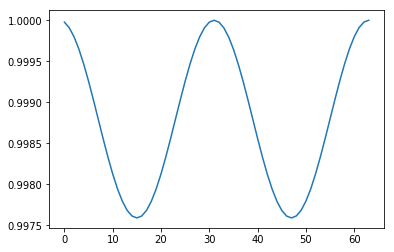

In [31]:
plt.plot([p @ p for p in orbit])
pass

##### Accuracy

In [32]:
la.norm(np.array([1.0,0.0]) - orbit[-1])

0.0025229913808033464

##### Conservation of energy

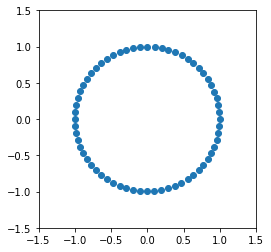

In [33]:
ax = plt.subplot(111)
plt.plot(orbit[:, 0], orbit[:,1], 'o')
ax.axis('square')
plt.axis([-1.5, 1.5, -1.5, 1.5])
pass

#### From Hamiltonians to probability distributions

The physical analogy considers the negative log likelihood of the target distribution $p(x)$ to correspond to a potential energy well, with a collection of particles moving on the surface of the well. The state of each particle is given only by its position and momentum (or velocity if we assume unit mass for each particle). In a Hamiltonian system, the total energy $H(x,, v) = U(x) + K(v)$ is conserved. From statistical mechanics, the probability of each state is related to the total energy of the system

$$
\begin{align}
p(x, v) & \propto e^{-H(x, v)} \\
&= e^{-U(x) - K(v)} \\
&= e^{-P(x)}e^{-K(v)} \\
& \propto p(x) \, p(v)
\end{align}
$$

Since the joint distribution factorizes $p(x, v) = p(x)\, p(v)$, we can select an initial random $v$ for a particle, numerically integrate using a finite difference method such as the leapfrog and then use the updated $x^*$ as the new proposal. The acceptance ratio for the new $x^*$ is

$$
\frac{ e^{ -U(x^*)-K(v^*) }} { e^{-U(x)-K(v)} } = e^{U(x)-U(x^*)+K(x)-K(x^*)}
$$

If our finite difference scheme was exact, the acceptance ration would be 1 since energy is conserved with Hamiltonian dynamics. However, as we have seen, the leapfrog method does not conserve energy perfectly and an accept/reject step is still needed.

#### Example of HMC

We will explore how HMC works when the target distribution is bivariate normal centered at zero

$$
x \sim N(0, \Sigma)
$$

In practice of course, the target distribution will be the posterior distribution and depend on both data and distributional parameters.

The potential energy or negative log likelihood is proportional to
$$
U(x) = \frac{x^T\Sigma^{-1} x}{2}
$$

The kinetic energy is given by
$$
K(v) = \frac{v^T v}{2}
$$ 

where the initial $v_0$ is chosen at random from the unit normal at each step.

To find the time updates, we use the Hamiltonian equations and find the first derivatives of total energy with respect to $x$ and $v$

$$
\begin{align}
x' &= \frac{\delta K}{\delta v} &= v \\
v' &= -\frac{\delta U}{\delta x} &= -\Sigma^{-1} x \\
\end{align}
$$

giving us the block matrix

$$
A = \pmatrix{0 & 1 \\ -\Sigma^{-1} & 0}
$$

By using the first derivatives, we are making use of the gradient information on the log posterior to guide the proposal distribution.

#### This is what the target distribution should look like

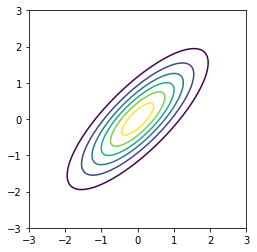

In [34]:
sigma = np.array([[1,0.8],[0.8,1]])
mu = np.zeros(2)

dist = stats.multivariate_normal(mu, sigma)

x = np.linspace(-3.0, 3.0, 100)
y = np.linspace(-3.0, 2.0, 100)
X, Y = np.meshgrid(x, y)
Z = dist.pdf(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)

plt.contour(X, Y, Z)
plt.axis('square')
pass

#### This is the HMC posterior

In [35]:
def E(A, u0, v0, u, v):
    """Total energy."""
    return (u0 @ tau @ u0 + v0 @ v0) - (u @ tau@u + v @ v)

In [36]:
def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h/2 * A @ u
    for i in range(N-1):
        u = u + h * v
        v = v - h * A @ u

    u = u + h * v
    v = v - h/2 * A @ u

    return u, v

In [37]:
niter = 100
h = 0.01
N = 100

A = np.array([[0,1],[-1,0]])

tau = la.inv(sigma)

orbit = np.zeros((niter+1, 2))
u = np.array([-2,2])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)

    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(A, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

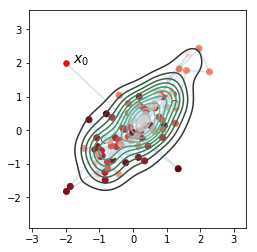

In [38]:
sns.kdeplot(orbit[:, 0], orbit[:, 1])
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.text(-1.8,2,'$x_0$', fontsize=14)
plt.axis('square')
pass

### Hierarchical models

Hierarchical models have the following structure - first we specify that the data come from a distribution with parameters $\theta$

$$
X \sim f(X\ | \ \theta)
$$

and that the parameters themselves come from another distribution with hyperparameters $\lambda$

$$
\theta \sim g(\theta \ | \ \lambda)
$$

and finally that $\lambda$ comes from a prior distribution

$$ 
\lambda \sim h(\lambda)
$$

More levels of hierarchy are possible - i.e you can specify hyper-hyperparameters for the distribution of $\lambda$ and so on.

The essential idea of the hierarchical model is because the $\theta$s are not independent but rather are drawn from a common distribution with parameter $\lambda$, we can share information across the $\theta$s by also estimating $\lambda$ at the same time. 

As an example, suppose have data about the proportion of heads after some number of tosses from several coins, and we want to estimate the bias of each coin. We also know that the coins come from the same mint and so might share some common manufacturing defect. There are two extreme approaches - we could estimate the bias of each coin from its coin toss data independently of all the others, or we could pool the results together and estimate the same bias for all coins. Hierarchical models provide a compromise where we shrink individual estimates towards a common estimate.

Note that because of the conditionally independent structure of hierarchical models, Gibbs sampling is often a natural choice for the MCMC sampling strategy.

#### Gibbs sampler example from [Robert and Casella, 10.17](http://www.springer.com/statistics/statistical+theory+and+methods/book/978-0-387-21239-5)

Suppose we have data of the number of failures ($y_i$) for each of 10 pumps in a nuclear plant. We also have the times ($_i$) at which each pump was observed. We want to model the number of failures with a Poisson likelihood, where the expected number of failure $\lambda_i$ differs for each pump. Since the time which we observed each pump is different, we need to scale each $\lambda_i$ by its observed time $t_i$.

We now specify the hierarchical model - note change of notation from the overview above - that $\theta$ is $\lambda$ (parameter) and $\lambda$ is $\beta$ (hyperparameter) simply because $\lambda$ is traditional for the Poisson distribution parameter. 

The likelihood $f$ is 
$$
\prod_{i=1}^{10} \text{Poisson}(\lambda_i t_i)
$$

We let the prior $g$ for $\lambda$ be 

$$
\lambda \sim \text{Gamma}(\alpha, \beta)
$$
with $\alpha = 1.8$ (an improper prior whose integral does not sum to 1)

and let the hyperprior $h$ for $\beta$ to be 

$$
\beta \sim \text{Gamma}(\gamma, \delta)
$$

with $\gamma = 0.01$ and $\delta = 1$.

There are 11 unknown parameters (10 $\lambda$s and $\beta$) in this hierarchical model.

The posterior is 
$$
p(\lambda, \beta \ | \ y, t) = \prod_{i=1}^{10} \text{Poisson}(\lambda_i t_i) \times \text{Gamma}(\alpha, \beta) \times \text{Gamma}(\gamma, \delta)
$$

with the conditional distributions needed for Gibbs sampling given by

$$
p(\lambda_i \ | \ \lambda_{-i}, \beta, y, t) = \text{Gamma}(y_i + \alpha, t_i + \beta)
$$

and 

$$
p(\beta \ | \ \lambda, y, t) = \text{Gamma}(10\alpha + \gamma, \delta + \sum_{i=1}^10 \lambda_i)
$$

In [39]:
from numpy.random import gamma as rgamma # rename so we can use gamma for parameter name

In [40]:
def lambda_update(alpha, beta, y, t):
    return rgamma(size=len(y), shape=y+alpha, scale=1.0/(t+beta))

def beta_update(alpha, gamma, delta, lambd, y):
    return rgamma(size=1, shape=len(y) * alpha + gamma, scale=1.0/(delta + lambd.sum()))

def gibbs(niter, y, t, alpha, gamma, delta):
    lambdas_ = np.zeros((niter, len(y)), np.float)
    betas_ = np.zeros(niter, np.float)
    
    lambda_ = y/t

    for i in range(niter):
        beta_ = beta_update(alpha, gamma, delta, lambda_, y)
        lambda_ = lambda_update(alpha, beta_, y, t)

        betas_[i] = beta_
        lambdas_[i,:] = lambda_
        
    return betas_, lambdas_

In [41]:
alpha = 1.8
gamma = 0.01
delta = 1.0
beta0 = 1
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22], np.int)
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48], np.float)
niter = 1000

In [42]:
betas, lambdas = gibbs(niter, y, t, alpha, gamma, delta)
print('%.3f' % betas.mean())
print('%.3f' % betas.std(ddof=1))
print(lambdas.mean(axis=0))
print(lambdas.std(ddof=1, axis=0))

2.413
0.688
[0.07170175 0.15396935 0.10465642 0.12387877 0.64406695 0.61179004
 0.84305929 0.85584759 1.33038796 1.85643359]
[0.02764277 0.09410763 0.04150302 0.03185053 0.2946104  0.13278886
 0.57377361 0.52315636 0.60987176 0.4113526 ]


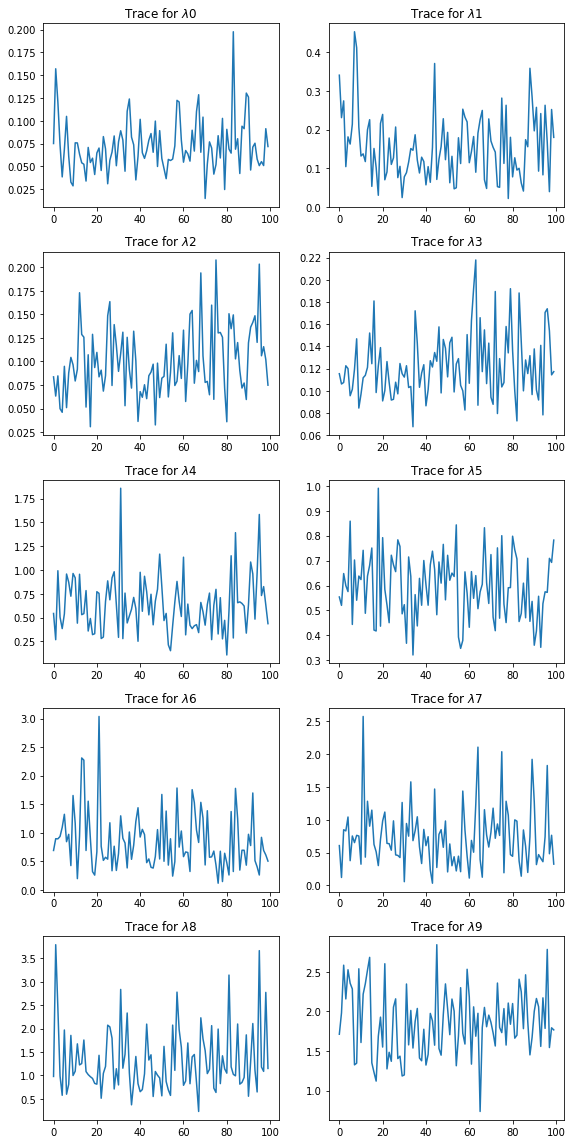

In [43]:
plt.figure(figsize=(8, 16))
for i in range(len(lambdas.T)):
    plt.subplot(5,2,i+1)
    plt.plot(lambdas[::10, i]);
    plt.title('Trace for $\lambda$%d' % i)
plt.tight_layout()